# 🍷 Youth Alcohol Use Prediction Using Tree-Based Models

This notebook explores social, behavioral, and demographic factors contributing to alcohol consumption among youth using decision tree-based methods.

We use machine learning problem type:
- **Multiclass Classification** (Seldom / Sometimes / Frequent)

We evaluate Decision Tree, Bagging, Random Forest, and Gradient Boosting models using accuracy, F1-score, confusion matrices.

In [36]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree,export_text
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree, DecisionTreeRegressor

In [57]:
# Load data
df = pd.read_csv("youth_data.csv")

missing_codes = [91, 93, 94, 97, 98, 99, 991, 993, 994, 995, 996, 997, 998, 999]
df.replace(missing_codes, np.nan, inplace=True)

# Remove rows with invalid ALCYDAYS = 6
df = df[df['ALCYDAYS'] != 6]

def map_alc_use(x):
    if x in [1, 2]:
        return 2   
    elif x == 3:
        return 1  
    elif x in [4, 5]:
        return 0  

df['ALC_CLASS'] = df['ALCYDAYS'].apply(map_alc_use)

# Predictor variables
predictors = [
    'EDUSCHGRD2', 'TOBFLAG', 'NEWRACE2', 'INCOME', 'POVERTY3',
    'HEALTH2', 'PRPROUD2', 'PRVDRGO2', 'PREVIOL2', 'FRDADLY2',
    'FRDMJMON', 'DRPRVME3', 'PRTALK3', 'TALKPROB', 'EDUSKPCOM', 'SCHFELT'
]

df = df.dropna(subset=predictors + ['ALC_CLASS'])

# Convert select columns to categorical
categorical_vars = ['EDUSCHGRD2', 'NEWRACE2', 'INCOME', 'POVERTY3']
for col in categorical_vars:
    df[col] = df[col].astype("category")

X = df[predictors]
y = df['ALC_CLASS']

print("Class distribution in full dataset:")
print(y.value_counts())
print("\nClass proportion (%):")
print(y.value_counts(normalize=True).round(3) * 100)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

dt_model = DecisionTreeClassifier(class_weight='balanced', random_state=42)
dt_model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("\n Classification Report – Decision Tree:")
print(classification_report(y_test, y_pred, target_names=["Seldom", "Sometimes", "Frequent"]))

# Confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
print("\n Confusion Matrix:")
print(pd.DataFrame(
    conf_mat,
    index=["Actual: Seldom", "Actual: Sometimes", "Actual: Frequent"],
    columns=["Predicted: Seldom", "Predicted: Sometimes", "Predicted: Frequent"]
))

Class distribution in full dataset:
ALC_CLASS
2    1110
1     117
0      60
Name: count, dtype: int64

Class proportion (%):
ALC_CLASS
2    86.2
1     9.1
0     4.7
Name: proportion, dtype: float64

 Classification Report – Decision Tree:
              precision    recall  f1-score   support

      Seldom       0.00      0.00      0.00        18
   Sometimes       0.30      0.09      0.13        35
    Frequent       0.87      0.96      0.91       334

    accuracy                           0.84       387
   macro avg       0.39      0.35      0.35       387
weighted avg       0.78      0.84      0.80       387


 Confusion Matrix:
                   Predicted: Seldom  Predicted: Sometimes  \
Actual: Seldom                     0                     1   
Actual: Sometimes                  0                     3   
Actual: Frequent                   6                     6   

                   Predicted: Frequent  
Actual: Seldom                      17  
Actual: Sometimes            

In [24]:
tree_summary = export_text(dt_model, feature_names=X.columns.tolist())
print(tree_summary)

|--- TOBFLAG <= 0.50
|   |--- NEWRACE2 <= 2.50
|   |   |--- HEALTH2 <= 2.50
|   |   |   |--- PRTALK3 <= 1.50
|   |   |   |   |--- EDUSKPCOM <= 9.00
|   |   |   |   |   |--- PRVDRGO2 <= 1.50
|   |   |   |   |   |   |--- DRPRVME3 <= 1.50
|   |   |   |   |   |   |   |--- class: 2
|   |   |   |   |   |   |--- DRPRVME3 >  1.50
|   |   |   |   |   |   |   |--- SCHFELT <= 1.50
|   |   |   |   |   |   |   |   |--- EDUSKPCOM <= 1.50
|   |   |   |   |   |   |   |   |   |--- class: 2
|   |   |   |   |   |   |   |   |--- EDUSKPCOM >  1.50
|   |   |   |   |   |   |   |   |   |--- class: 2
|   |   |   |   |   |   |   |--- SCHFELT >  1.50
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- PRVDRGO2 >  1.50
|   |   |   |   |   |   |--- FRDADLY2 <= 1.50
|   |   |   |   |   |   |   |--- INCOME <= 3.50
|   |   |   |   |   |   |   |   |--- class: 2
|   |   |   |   |   |   |   |--- INCOME >  3.50
|   |   |   |   |   |   |   |   |--- EDUSCHGRD2 <= 4.50
|   |   |   |   |   |   |   |   |   

In [25]:
importances = pd.DataFrame({'feature_name': X.columns, 'importance': dt_model.feature_importances_})
importances = importances.sort_values('importance', ascending=False).reset_index(drop=True)
print(importances)

   feature_name  importance
0    EDUSCHGRD2    0.185998
1     EDUSKPCOM    0.118044
2       HEALTH2    0.097645
3        INCOME    0.093621
4       SCHFELT    0.064254
5      NEWRACE2    0.062248
6       TOBFLAG    0.058345
7      POVERTY3    0.050283
8       PRTALK3    0.047709
9      DRPRVME3    0.047629
10     PRPROUD2    0.041846
11     FRDADLY2    0.041125
12     FRDMJMON    0.036322
13     PRVDRGO2    0.032185
14     TALKPROB    0.019460
15     PREVIOL2    0.003288


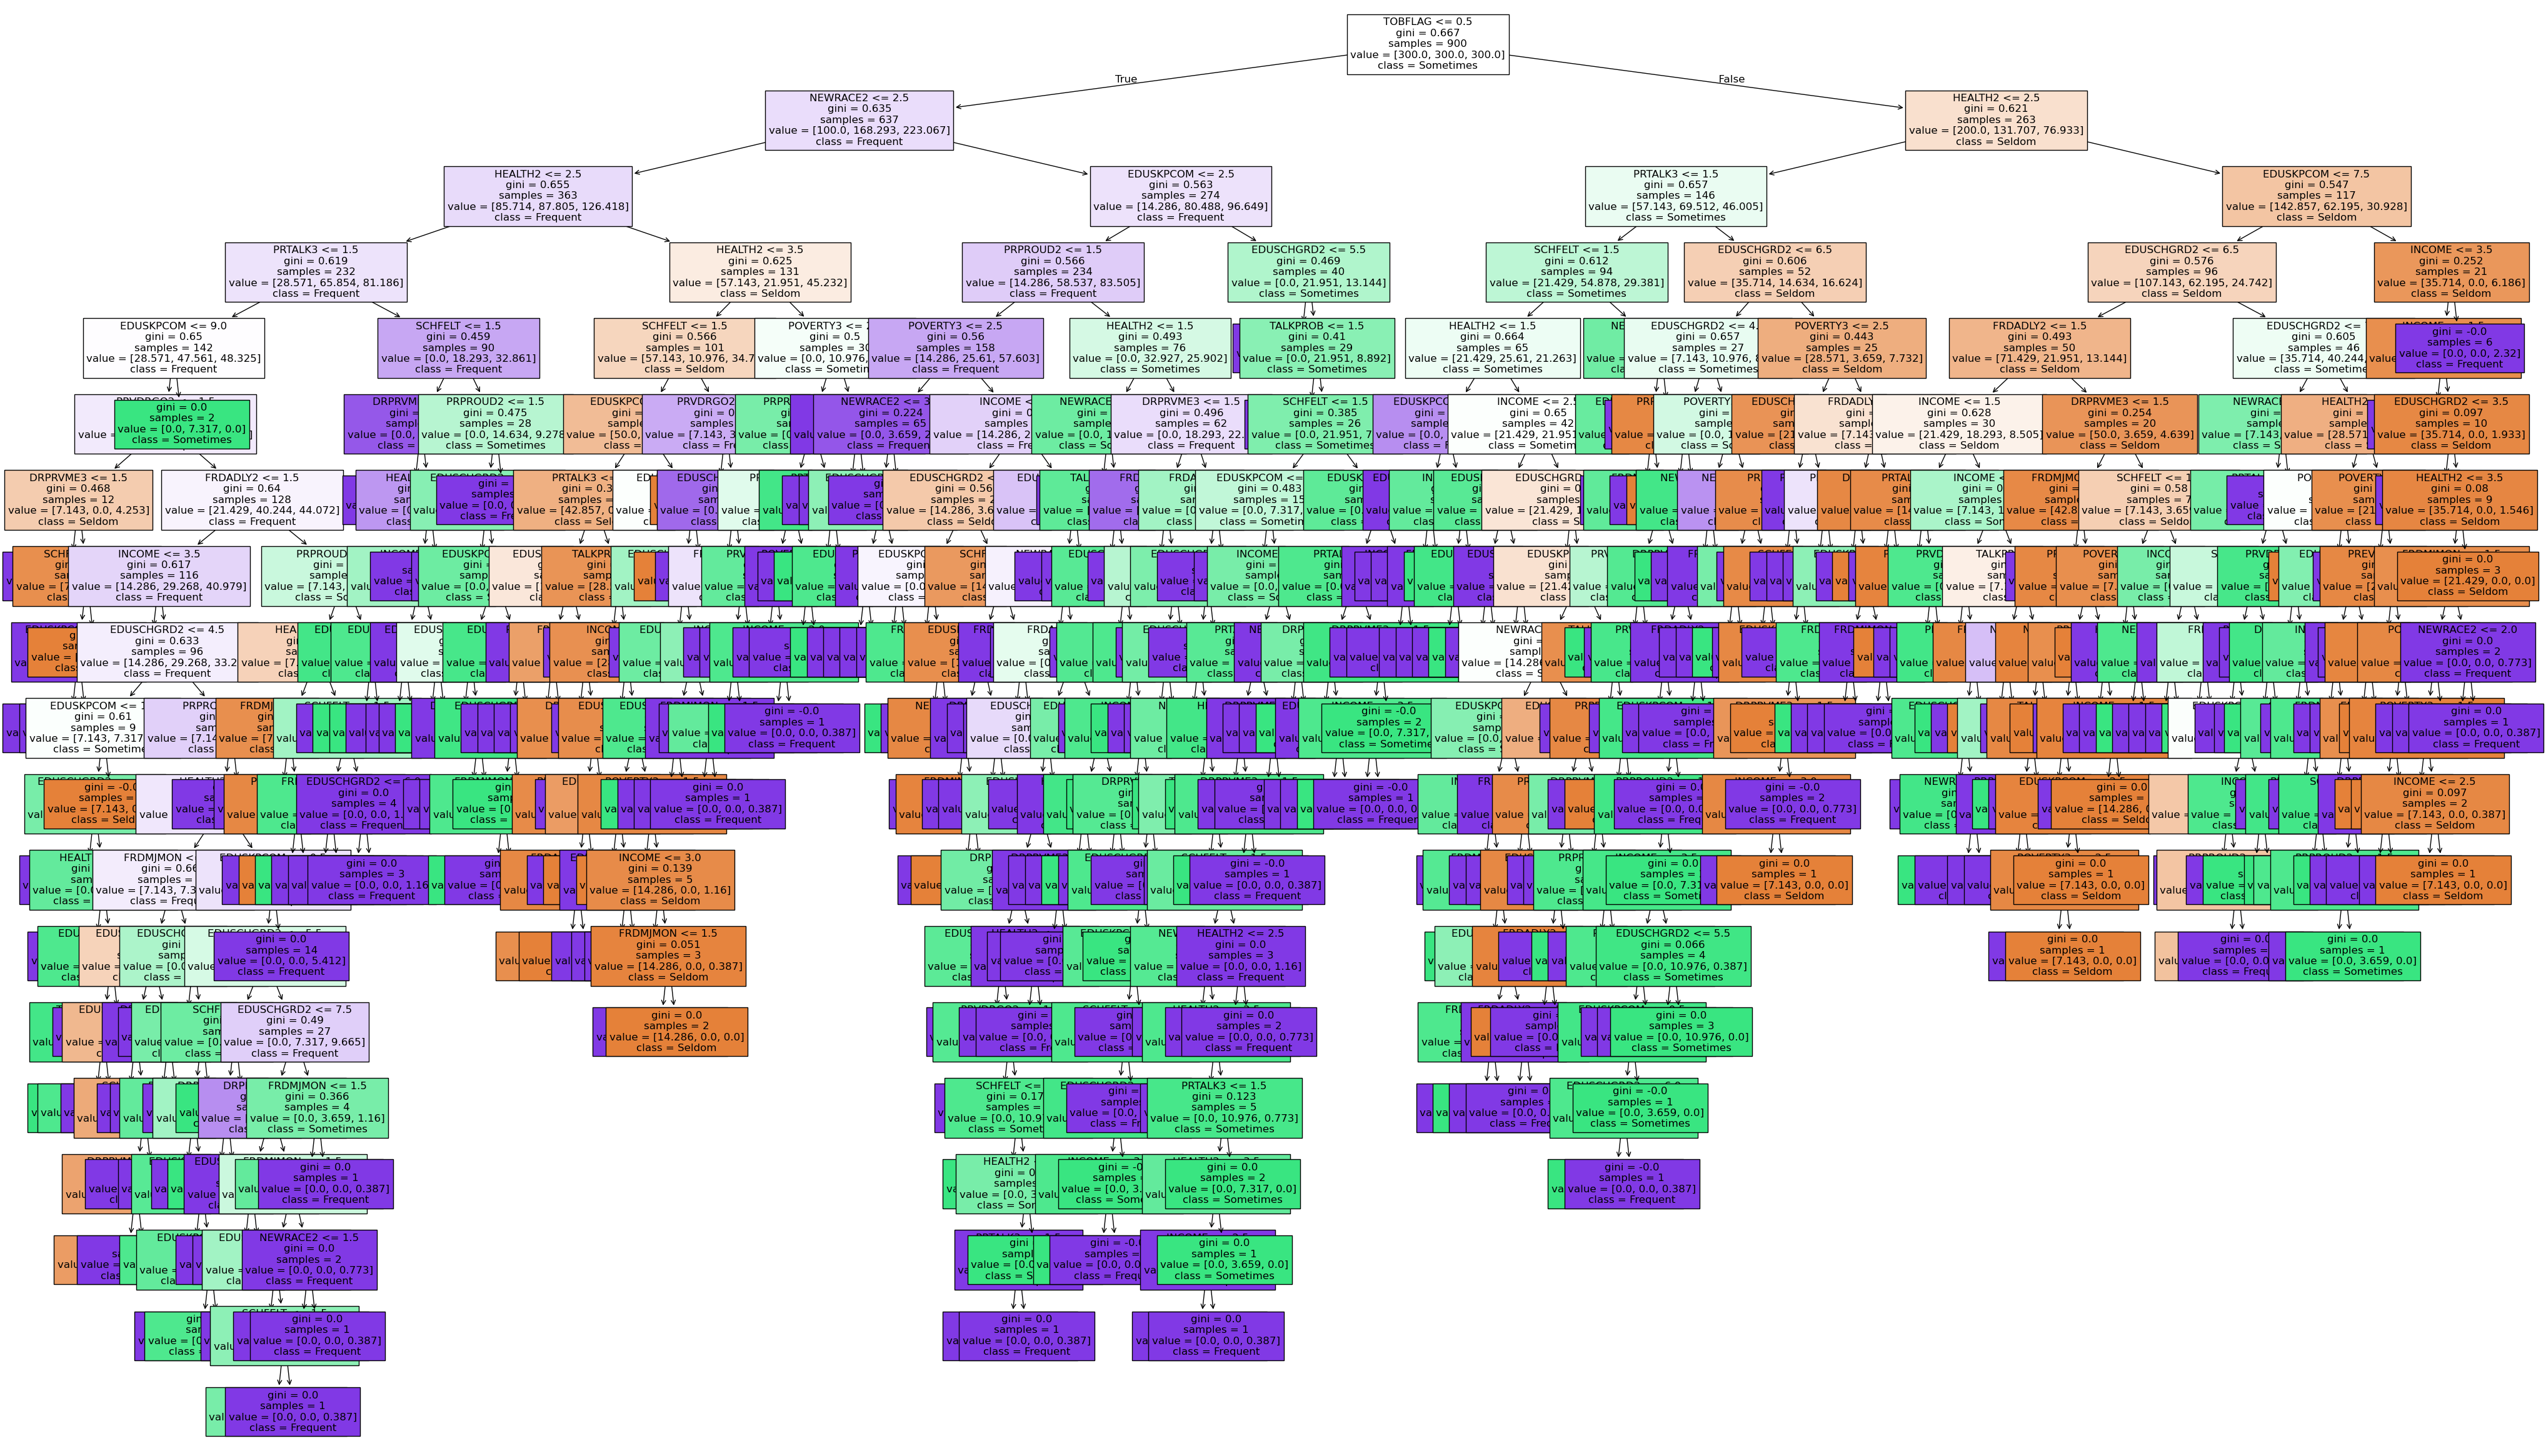

In [26]:

plt.figure(figsize=(50, 30))
plot_tree(
    dt_model,
    filled=True,
    feature_names=X.columns,
    class_names=['Seldom', 'Sometimes', 'Frequent'],
    label='all',
    fontsize=12
)
plt.show()

In [40]:
y_pred_dt = dt_model.predict(X_test)
acc = accuracy_score(y_test, y_pred_dt)
print("Accuracy: {:.2f}%".format(acc * 100))

Accuracy: 76.23%


The Best Tree Size is : 3


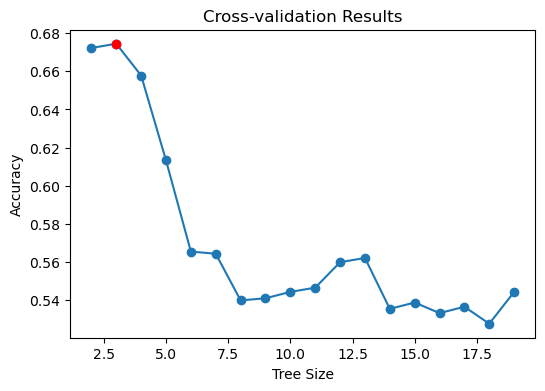

In [28]:
params = {'max_leaf_nodes': range(2, 20)}  
cv_binary = GridSearchCV(dt_model, params, cv=10)
cv_binary.fit(X_train, y_train)
cv_results = cv_binary.cv_results_

# find the best score for max leaf nodes
best_size = cv_binary.best_params_['max_leaf_nodes']
best_score = cv_binary.best_score_

# plot results of cross-validation
plt.figure(figsize=(6, 4))
plt.plot(cv_results["param_max_leaf_nodes"], cv_results["mean_test_score"], 'o-')
plt.plot(best_size, best_score, 'ro-')
plt.xlabel('Tree Size')
plt.ylabel('Accuracy')
plt.title('Cross-validation Results');
print("The Best Tree Size is :", best_size)


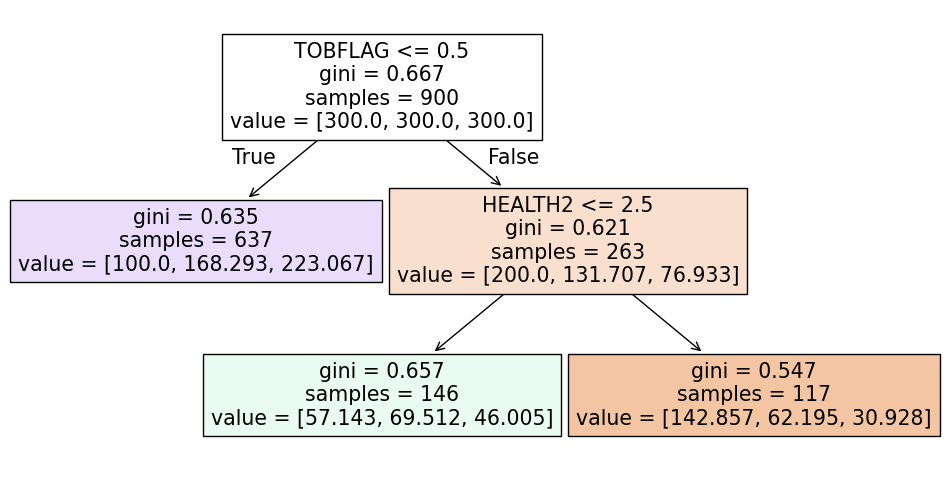

In [29]:
prune_binary = DecisionTreeClassifier(
    max_leaf_nodes=best_size,
    random_state=7,
    class_weight='balanced'
)
prune_binary.fit(X_train, y_train)

plt.figure(figsize=(12,6))
plt.title('Pruned Tree')
plot_tree(prune_binary, feature_names=X_train.columns, filled=True);

In [30]:
trees_summary = export_text(prune_binary, feature_names=X.columns.tolist())
print(trees_summary)

|--- TOBFLAG <= 0.50
|   |--- class: 2
|--- TOBFLAG >  0.50
|   |--- HEALTH2 <= 2.50
|   |   |--- class: 1
|   |--- HEALTH2 >  2.50
|   |   |--- class: 0



In [31]:
y_pred = prune_binary.predict(X_test)

confusion_matrix = pd.crosstab(index=y_pred, columns=y_test, rownames=[''])
print(confusion_matrix)

ALC_CLASS  0   1    2
                     
0          7   4   50
1          9  12   45
2          2  19  239


In [32]:
accuracy_prune = prune_binary.score(X_test, y_test)
print("Accuracy: {:.2f}%".format(accuracy_prune*100))

Accuracy: 66.67%


In [33]:
# Random Forest 

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_features='sqrt',  
    class_weight='balanced',
    random_state=42
)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

In [34]:
# Gradient Boost(Boosting Model)

gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)
gb_model.fit(X_train, y_train, sample_weight=sample_weights)
y_pred_gb = gb_model.predict(X_test)

In [41]:
#Classification Report 
models = {
    "Decision Tree": (dt_model, y_pred_dt),
    "Random Forest": (rf_model, y_pred_rf),
    "Gradient Boosting": (gb_model, y_pred_gb)
}

for name, (model, pred) in models.items():
    print(f"\n🧪 {name}")
    print("Accuracy:", accuracy_score(y_test, pred))
    print("Classification Report:")
    print(classification_report(y_test, pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, pred))


🧪 Decision Tree
Accuracy: 0.7622739018087855
Classification Report:
              precision    recall  f1-score   support

           0       0.14      0.17      0.15        18
           1       0.14      0.14      0.14        35
           2       0.88      0.86      0.87       334

    accuracy                           0.76       387
   macro avg       0.38      0.39      0.39       387
weighted avg       0.77      0.76      0.77       387

Confusion Matrix:
[[  3   4  11]
 [  0   5  30]
 [ 19  28 287]]

🧪 Random Forest
Accuracy: 0.8449612403100775
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        18
           1       0.33      0.06      0.10        35
           2       0.86      0.97      0.92       334

    accuracy                           0.84       387
   macro avg       0.40      0.34      0.34       387
weighted avg       0.78      0.84      0.80       387

Confusion Matrix:
[[  0   0  18]
 [ 

In [55]:
from sklearn.preprocessing import label_binarize

y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_binarized.shape[1]

plt.figure(figsize=(8, 6))
for name, model in models.items():
    if hasattr(model[0], "predict_proba"):
        y_score = model[0].predict_proba(X_test)
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
            auc_score = roc_auc_score(y_test_binarized[:, i], y_score[:, i])
            plt.plot(fpr, tpr, label=f"{name} (class {i}) AUC = {auc_score:.2f}")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve – Alcohol Use Prediction")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

AttributeError: 'list' object has no attribute 'items'

<Figure size 800x600 with 0 Axes>

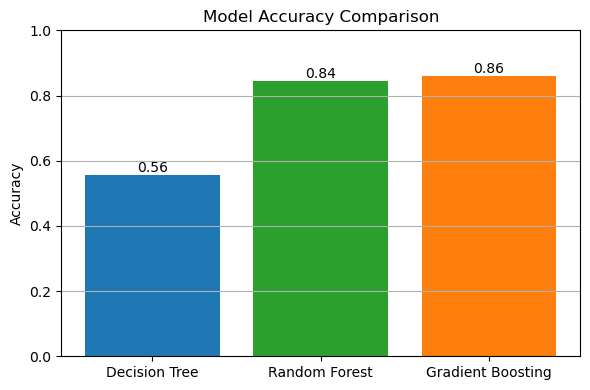

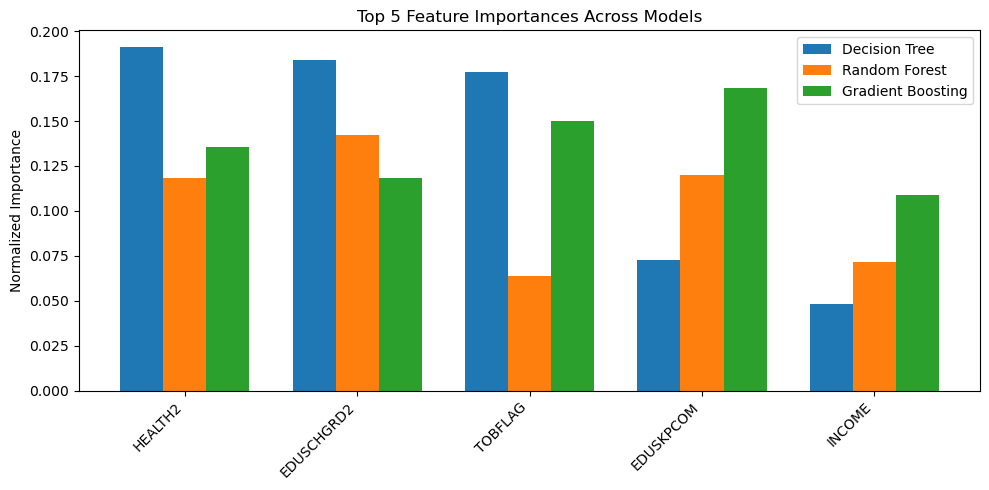

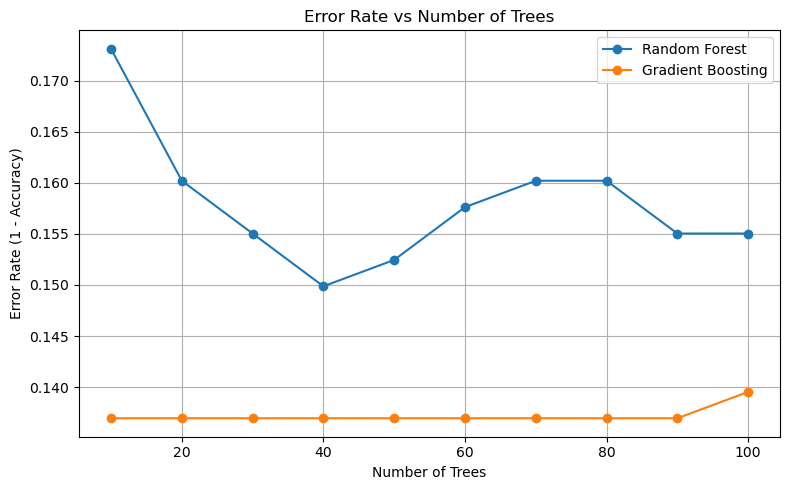

In [43]:
dt_model = DecisionTreeClassifier(class_weight='balanced', max_depth=5, random_state=42)
dt_model.fit(X_train, y_train)
rf_model = RandomForestClassifier(n_estimators=100, max_features='sqrt', class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.05, max_depth=3, random_state=42)
gb_model.fit(X_train, y_train)

y_pred_dt = dt_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)
y_pred_gb = gb_model.predict(X_test)

# Accuracy Plot
accuracies = [
    accuracy_score(y_test, y_pred_dt),
    accuracy_score(y_test, y_pred_rf),
    accuracy_score(y_test, y_pred_gb)
]
labels = ['Decision Tree', 'Random Forest', 'Gradient Boosting']
plt.figure(figsize=(6, 4))
bars = plt.bar(labels, accuracies, color=['#1f77b4', '#2ca02c', '#ff7f0e'])
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{bar.get_height():.2f}', ha='center')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Feature Importances
features = X_train.columns
importance_df = pd.DataFrame({
    'Feature': features,
    'Decision Tree': dt_model.feature_importances_,
    'Random Forest': rf_model.feature_importances_,
    'Gradient Boosting': gb_model.feature_importances_
})
importance_df[['Decision Tree', 'Random Forest', 'Gradient Boosting']] = importance_df[
    ['Decision Tree', 'Random Forest', 'Gradient Boosting']
].div(importance_df[['Decision Tree', 'Random Forest', 'Gradient Boosting']].sum(), axis=1)
importance_df['Average'] = importance_df[['Decision Tree', 'Random Forest', 'Gradient Boosting']].mean(axis=1)
importance_df = importance_df.sort_values('Average', ascending=False).head(5)

# Plot Feature Importances
x = np.arange(len(importance_df))
width = 0.25
plt.figure(figsize=(10, 5))
plt.bar(x - width, importance_df['Decision Tree'], width=width, label='Decision Tree')
plt.bar(x, importance_df['Random Forest'], width=width, label='Random Forest')
plt.bar(x + width, importance_df['Gradient Boosting'], width=width, label='Gradient Boosting')
plt.xticks(x, importance_df['Feature'], rotation=45, ha='right')
plt.ylabel("Normalized Importance")
plt.title("Top 5 Feature Importances Across Models")
plt.legend()
plt.tight_layout()
plt.show()

# Error vs. n_estimators
tree_range = range(10, 110, 10)
bag_err, rf_err, gb_err = [], [], []
for n in tree_range:
    rf = RandomForestClassifier(n_estimators=n, max_features='sqrt', class_weight='balanced', random_state=42)
    rf.fit(X_train, y_train)
    gb = GradientBoostingClassifier(n_estimators=n, learning_rate=0.05, max_depth=3, random_state=42)
    gb.fit(X_train, y_train)
    
    rf_err.append(1 - accuracy_score(y_test, rf.predict(X_test)))
    gb_err.append(1 - accuracy_score(y_test, gb.predict(X_test)))

# Plot Error vs Trees
plt.figure(figsize=(8, 5))
plt.plot(tree_range, rf_err, marker='o', label='Random Forest')
plt.plot(tree_range, gb_err, marker='o', label='Gradient Boosting')
plt.xlabel("Number of Trees")
plt.ylabel("Error Rate (1 - Accuracy)")
plt.title("Error Rate vs Number of Trees")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

🔍 Random Forest Results (Tuned)
Best Params: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100}
Accuracy: 0.8423772609819121


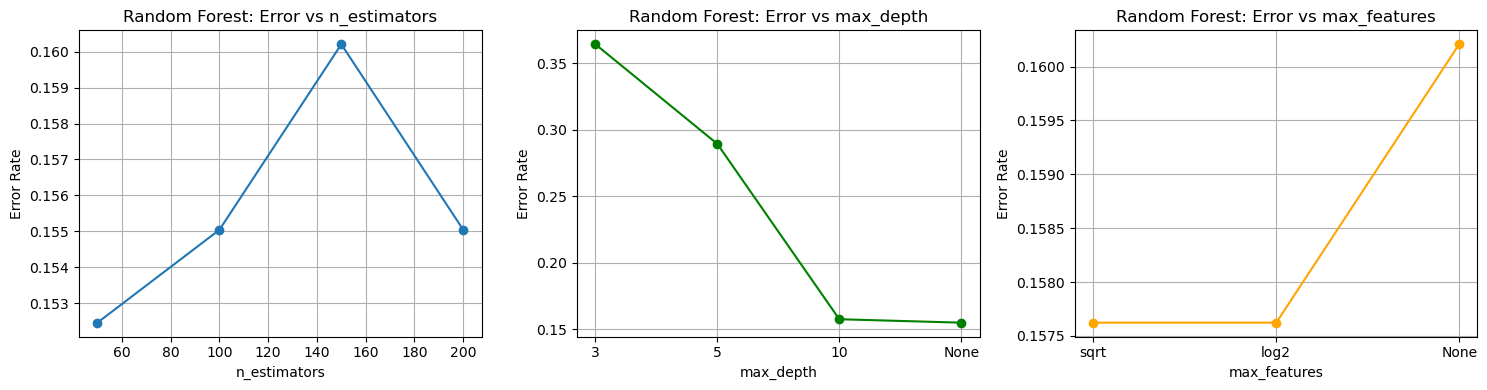

In [54]:



rf_params = {
    'n_estimators': [100, 150],
    'max_depth': [5, 10],
    'max_features': ['sqrt', 'log2', None]
}

rf_grid = GridSearchCV(
    estimator=RandomForestClassifier(
        class_weight='balanced',
        random_state=42
    ),
    param_grid=rf_params,
    cv=5,
    n_jobs=-1,
    scoring='accuracy'
)

rf_grid.fit(X_train, y_train)
rf_model = rf_grid.best_estimator_

print("🔍 Random Forest Results (Tuned)")
print("Best Params:", rf_grid.best_params_)
y_pred_rf = rf_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_rf))

# === Error vs max_features ===
feature_options = ['sqrt', 'log2', None]
rf_errors_features = []

for f in feature_options:
    model = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        max_features=f,
        class_weight='balanced',
        random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rf_errors_features.append(1 - accuracy_score(y_test, y_pred))

plt.figure(figsize=(15, 4))

# Plot: Error vs n_estimators
plt.subplot(1, 3, 1)
plt.plot(rf_estimators, rf_errors_estimators, marker='o')
plt.title("Random Forest: Error vs n_estimators")
plt.xlabel("n_estimators")
plt.ylabel("Error Rate")
plt.grid(True)

# Plot: Error vs max_depth
plt.subplot(1, 3, 2)
plt.plot([str(d) for d in rf_depths], rf_errors_depth, marker='o', color='green')
plt.title("Random Forest: Error vs max_depth")
plt.xlabel("max_depth")
plt.ylabel("Error Rate")
plt.grid(True)

# Plot: Error vs max_features
plt.subplot(1, 3, 3)
plt.plot(['sqrt', 'log2', 'None'], rf_errors_features, marker='o', color='orange')
plt.title("Random Forest: Error vs max_features")
plt.xlabel("max_features")
plt.ylabel("Error Rate")
plt.grid(True)

plt.tight_layout()
plt.show()

 Gradient Boosting Results (Tuned)
Best Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Accuracy: 0.7751937984496124
Confusion Matrix:
 [[  0   5  13]
 [  0   6  29]
 [ 13  27 294]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        18
           1       0.16      0.17      0.16        35
           2       0.88      0.88      0.88       334

    accuracy                           0.78       387
   macro avg       0.34      0.35      0.35       387
weighted avg       0.77      0.78      0.77       387



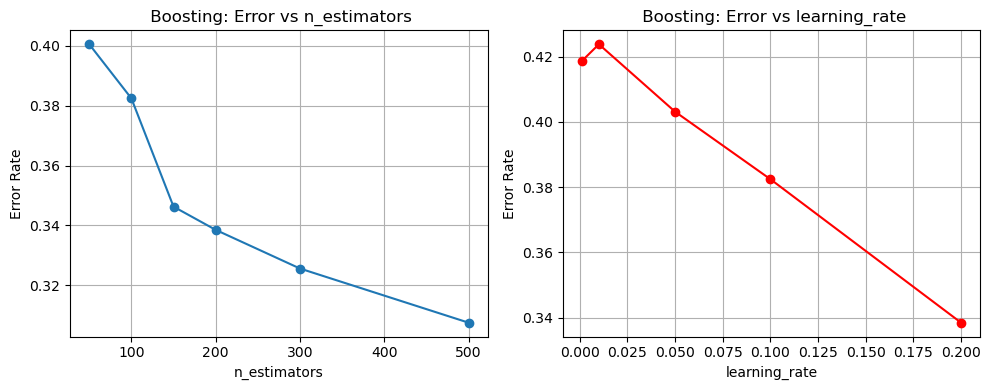

In [51]:

gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)
gb_model.fit(X_train, y_train, sample_weight=sample_weights)
y_pred_gb = gb_model.predict(X_test)


gb_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'max_depth': [3, 5]
}

gb_grid = GridSearchCV(
    estimator=GradientBoostingClassifier(random_state=42),
    param_grid=gb_params,
    cv=5,
    n_jobs=-1,
    scoring='accuracy'
)

gb_grid.fit(X_train, y_train, sample_weight=sample_weights)
gb_model = gb_grid.best_estimator_
y_pred_gb = gb_model.predict(X_test)

print(" Gradient Boosting Results (Tuned)")
print("Best Params:", gb_grid.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_gb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_gb))
print("Classification Report:\n", classification_report(y_test, y_pred_gb))


gb_estimators = [50, 100, 150, 200,300,500]
gb_lrs = [0.001,0.01, 0.05, 0.1, 0.2]
gb_errors_estimators, gb_errors_lr = [], []

for n in gb_estimators:
    model = GradientBoostingClassifier(
        n_estimators=n,
        learning_rate=0.1,
        max_depth=3,
        random_state=42
    )
    model.fit(X_train, y_train, sample_weight=sample_weights)
    y_pred = model.predict(X_test)
    gb_errors_estimators.append(1 - accuracy_score(y_test, y_pred))

for lr in gb_lrs:
    model = GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=lr,
        max_depth=3,
        random_state=42
    )
    model.fit(X_train, y_train, sample_weight=sample_weights)
    y_pred = model.predict(X_test)
    gb_errors_lr.append(1 - accuracy_score(y_test, y_pred))


plt.figure(figsize=(10, 4))

# Error vs n_estimators
plt.subplot(1, 2, 1)
plt.plot(gb_estimators, gb_errors_estimators, marker='o')
plt.title(" Boosting: Error vs n_estimators")
plt.xlabel("n_estimators")
plt.ylabel("Error Rate")
plt.grid(True)

# Error vs learning_rate
plt.subplot(1, 2, 2)
plt.plot(gb_lrs, gb_errors_lr, marker='o', color='red')
plt.title(" Boosting: Error vs learning_rate")
plt.xlabel("learning_rate")
plt.ylabel("Error Rate")
plt.grid(True)

plt.tight_layout()
plt.show()

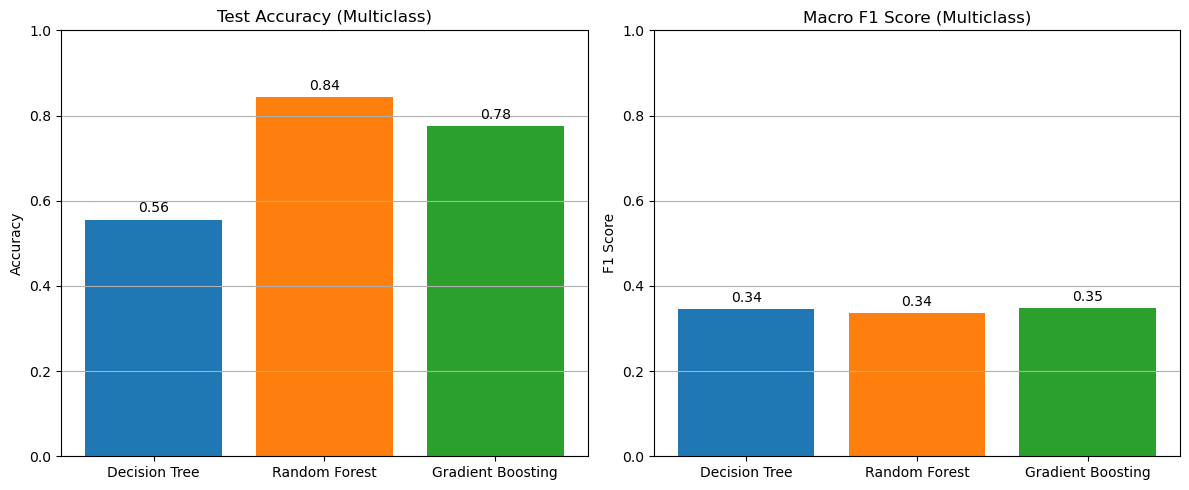

In [52]:
from sklearn.metrics import f1_score, accuracy_score

y_pred_dt = dt_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)
y_pred_gb = gb_model.predict(X_test)

accuracy_scores = [
    accuracy_score(y_test, y_pred_dt),
    accuracy_score(y_test, y_pred_rf),
    accuracy_score(y_test, y_pred_gb)
]

macro_f1_scores = [
    f1_score(y_test, y_pred_dt, average='macro'),
    f1_score(y_test, y_pred_rf, average='macro'),
    f1_score(y_test, y_pred_gb, average='macro')
]

models = ['Decision Tree', 'Random Forest', 'Gradient Boosting']

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
bars1 = plt.bar(models, accuracy_scores, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.title("Test Accuracy (Multiclass)")
plt.ylabel("Accuracy")
plt.ylim(0, 1.0)
plt.grid(axis='y')
for bar in bars1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01,
             f"{height:.2f}", ha='center', va='bottom', fontsize=10)

plt.subplot(1, 2, 2)
bars2 = plt.bar(models, macro_f1_scores, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.title("Macro F1 Score (Multiclass)")
plt.ylabel("F1 Score")
plt.ylim(0, 1.0)
plt.grid(axis='y')
for bar in bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01,
             f"{height:.2f}", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# 📊 Conclusions & Reflections

**Top Predictors**: Education grade level, marijuana age, peer influence, and race consistently ranked as top features.

**Best Models**:

  - **Multiclass Classification**: Boosting 
  - 
**Limitations**:
  - Class imbalance and poor recall for minority classes

## Potential Improvements

- Use **SMOTE** or **class reweighting** for better balance
- Try **ordinal classification** or dimensionality reduction (e.g., PCA)
- Consider testing additional features on mental health or social risk

This work can support better-targeted youth intervention strategies, highlighting the importance of early school engagement, family involvement, and peer environments.